## AlexNet (ImageNet Classification with Deep Convolutional Neural Networks)

AlexNet은 2012년 ILSVRC(ImageNet Large-Scale Visual Recognition Challenge)대회에서 Top error 기준 15.4%를 기록해 2위(26.2%)를 큰 폭으로 따돌리고 1위를 차지했습니다(Top5 test error란 모델이 예측한 최상위 5개 범주 가운데 정답이 없는 경우의 오류율을 말합니다). 이 AlexNet 덕분에, 특히 CNN이 세간의 주목을 받게 되었으며, CNN 구조의 GPU 구현과 dropout 적용이 보편화 되었습니다. 

### The Dataset 

1. 사용한 Data
- ImageNet dataset
    - 22,000개 범주로 구성되어 있고 1500만개의 고해상도 이미지가 포함되어 있는 dataset입니다. ILSVRC 대회는 ImageNet dataset의 subset을 이용하는데, 각 범주당 1000개의 이미지가 포함되어 있는 1000개 범주를 이용합니다. 따라서, 대략 120만개의 training 이미지와 50,000개의 validation 이미지, 150,000개의 test 이미지로 구성되어있습니다. 

2. data 전처리 
- 이미지 크기 256x256으로 고정 
    - 이미지를 동일한 크기(256x256)으로 고정시켜줬습니다. 나중에 FC layer의 입력 크기가 고정되어 있어야 하기 때문입니다. 만약 입력 이미지의 크기가 다르다면, FC layer에 입력되는 feature 개수가 모두 다르게 됩니다. resize 방법은 이미지의 넓이와 높이 중 짧은 쪽을 256으로 고정시키고 중앙 부분을 256x256 크기로 crop 해주었습니다. 
- 각 이미지의 pixel에 train set의 평균을 빼기 
    - 각 이미지의 pixel에 train set의 평균을 빼서 normalize 해주었습니다. 

### AlexNet Architecture 
- AlexNet은 일부가 max-pooling layer가 적용된 5개의 convolutional layer와 3개의 fully-connected layer로 이루어져있습니다. 
- AlexNet은 [Input layer - Conv1 - MaxPool1 - Norm1 - Conv2 - MaxPool2 - Norm2 - Conv3 - Conv4 - Conv5 - MaxPool3 - FC1 - FC2 - Output layer]로 구성되어 있습니다. 
---
- Input layer 
    - 224x224x3 크기의 이미지입니다.
- Conv1 
    - 96 kernels of size 11x11, stride=4, padding=0
    - input : 224x224x3
    - output : 55x55x96
- MaxPool1
    - 3x3 kernels, strid=2
    - input : 55x55x96
    - output : 27x27x96
- Norm1 
    - LRN을 사용한 normalization layer입니다.
    - input : 27x27x96
    - output : 27x27x96
- Conv2 
    - 256 kernels of size 5x5, stride=1, padding=2 (논문의 그림에는 3x3 size의 kernel을 사용했다고 나오는데 논문의 그림 잘못되었다고 합니다.)
    - input : 27x27x96
    - output : 27x27x256
- MaxPool2 
    - 3x3 kernels, stride=2 
    - input : 27x27x256
    - output : 13x13x256
- Norm2 
    - LRN을 사용한 normalization layer
    - input : 13x13x256
    - output : 13x13x256
- Conv3
    - 384 kernels of size 3x3, stride=1, padding=1
    - input : 13x13x256
    - output : 13x13x384
- Conv4
    - 384 kernels of size 3x3, stride=1, padding=1
    - input:13x13x384
    - output : 13x13x384
- Conv5
    - 256 kernels of size 3x3, stride=1, padding=1
    - input : 13x13x384
    - output : 13x13x256
- MaxPool3
    - 3x3 kernels, stride=2
    - input : 13x13x256
    - output : 6x6x256
- FC1
    - fully connected layer with 4096 neurons 
    - input : 6x6x256
    - output : 4096
- FC2 
    - fully connected layer with 4096 neurons
    - input : 4096
    - 4096
- output layer 
    - fully connected layer with 1000-way softmax
    - input : 4096
    - output : 1000
---

### AlexNet의 구조에 적용된 특징 
논문에서 AlexNet 구조에 적용된 특징들을 설명합니다.

1. ReLU Nonlinearity
    - 활성화 함수로 ReLU를 사용 
    - 논문에서는 saturating nonlinearity(tanh, sigmoid)보다 non-saturating nonlinearity(ReLU)의 학습 속도가 몇 배는 빠르다고 나와있습니다.
    - 저자는 논문에서 tanh와 ReLU의 학습 속도를 비교했을때 ReLU가 6배 정도 빠르다고 주장했습니다. 

2. Training on Multiple GPUs 
    - network를 2개의 GPU로 나누어 학습시켰습니다. 이를 GPU parallelization이라고 합니다. 저자는 120만개의 data를 학습시키기 위한 network는 하나의 GPU로 부족하다고 설명합니다. 2개의 GPU로 나누어서 학습시키니 top-1 error와 top-5 error가 1.7%, 1.2% 감소되었으며 학습속도도 빨라졌다고 말합니다.예를 들어, 90개의 kernel이 있다고 하면 45개를 GPU 1에 할당하고 남은 45개를 GPU 2에 할당하여 학습합니다. 
    - 여기서 추가적인 기법으로, 데이터를 두 개의 GPU로 나누어 학습시키다가 하나의 layer에서만 GPU를 통합시키는 것입니다. 논문에서는 3번째 Conv layer에서만 GPU를 통합시킨다고 말합니다. 이를 통해 계산랸의 허용 가능한 부분까지 통신량을 정확하게 조정할 수 있다고 나와있습니다.
    - GPU1, GPU2 각각에서 학습된 kernel map에서 GPU 1에서는  색상과 관련 없는 정보를 학습하고 GPU 2는 색상과 관련된 정보를 학습하는 것을 확인할 수 있다고 합니다. 이처럼 각각의 GPU는 독립적으로 학습된다고 나와있습니다. 

3. Local Response Normalization (LRN)  
    - https://towardsdatascience.com/difference-between-local-response-normalization-and-batch-normalization-272308c034ac
    - LRN은 generalization을 목적으로 합니다. sigmoid나 tanh 함수는 입력 data의 속성이 서로 편차가 심하면 saturating되는 현상이 심해져 vanishing gradient를 유발할 수 있게 됩니다. 반면에 ReLU는 non-saturating nonlinearity 함수이기 때문에 saturating을 예방하기 위한 입력 normalization이 필요하지 않는 성질을 갖고 있습니다. ReLU는 양수값을 받으면 그 값을 그대로 neuron에 전달하기 때문에 너무 큰 값이 전달되어 주변의 낮은 값이 neuron에 전달되는 것을 막을 수 있습니다. 이것을 예방하기 위한 normalization이 LRN입니다. 
    - 논문에서는 LRN을 측면 억제(later inhibition)의 형태로 구현된다고 나와있습니다. 측면 억제는 강한 자극이 주변의 약한 자극을 전달하는 것을 막는 효과를 말합니다. 
    - AlexNet에서 LRN을 구현한 수식입니다. 
    - a는 x,y 위치에 적용된 i 번째 kernel의 output을 의미하고 이 a를 normalization하여 큰 값이 주변의 약한 값에 영향을 주는 것을 최소화 했다고 나와 있습니다. 이러한 기법으로 top-1 error와 top-5 error를 각각 1.4%, 1.2% 감소시켰다고 합니다. 
    - 하지만 AlexNet 이후 현대의 CNN에서는 local reponse normalization 대신 batch normalization 기법이 쓰인다고 합니다. 

4. Overlapping Pooling 
    - Overlapping pooling을 통해서 overfitting을 방지하고 top-1 error와 top-5 error를 각각 0.4%, 0.3% 낮추었다고 말합니다. 
    - Pooling layer은 동일한 kernel map에 있는 인접한 neuron의 output을 요약해줍니다. 전통적으로 pooling layer는 overlap하지 않지만, AlexNet은 overlap을 해주었습니다. kernel size는 3, stride는 2를 적용하여 overlap을 해주었다고 나와있습니다. 


### Reducing Overfitting

AlexNet에는 6천 만개의 paramerters가 존재합니다. 이미지를 ILSVRC의 1000개 class로 분류하기 위해서는 overfitting 없이 수 많은 parameters를 학습 시키는 것은 어렵다고 말합니다. 그래서 논문에서는 overfitting을 피하기 위해 적용한 두 가지 기법을 소개합니다. 

1. Data Augmentation 
    - Data Augmentation은 현재 갖고 있는 데이터를 좀 더 다양하게 만들어 CNN 모델을 학습시키기 위해 만들어진 개념입니다. 이러한 기법은 적은 노력으로 다양한 데이터를 형성하게 하고, overfitting을 피하게 만들어 줍니다. 또한 data augmentation의 연산량은 매우 적고 CPU에서 이루어지기 때문에 계산적으로 부담이 없다고 말합니다. 
    - Generating image translation and horizontal reflections 
        - 이미지를 생성시키고 수평 반전을 해주었습니다. 
        - 256x256 이미지에서 224x224 크기로 crop을 합니다(이 때문에 데이터의 사이즈를 256x256로 바꾸고, input data : 224x224x3 입니다). crop 위치는 중앙, 좌측 상단, 좌측 하단, 우측 상단, 우측 하단 이렇게 5개의 위치에 crop을 합니다. crop으로 생성된 5개의 이미지를 horizontal reflection을 합니다. 따라서 하나의 이미지에서 10개의 이미지가 생성됩니다. 
    - Altering the intensities of the RGB channels in training images
        - image의 RGB pixel 값에 변화를 주었습니다. 
        - ImageNet의 train set에 RGB pixel 값에 대한 PCA를 적용했습니다. PCA를 수행하여 RGB 각 색상에 대한 eigenvalue를 찾습니다. eigenvalue와 평균 0, 분산 0.1인 가우시안 분포에서 추출한 랜덤 변수를 곱해서 RGB 값에 더해줍니다. 
        - 이를 통해 조명의 영향과 색의 intensity 변화에 대한 불변성을 지닌다고 합니다. 이 기법으로 top-1 error를 1% 낮추었다고 합니다.

2. Dropout 
    - 서로 다른 모델의 예측을 결합하는 앙상블 기법은 test error를 감소시키는 효과적인 방법입니다. 하지만 AlexNet은 학습시키는데 몇 일이 걸려 이것을 적용하기 힘들었다고 합니다. 따라서 모델 결합의 효과적인 Dropout을 적용시켰다고 합니다. 
    - Dropout의 확률을 0.5로 설정하고 Dropout된 neuron은 forward와 backward에 영향을 주지 않습니다. 매 입력마다 Dropout을 적용시키면 가중치는 공유되지만 신경망은 서로 다른 구조를 띄게 됩니다. neuron은 특정 다른 neuron의 존재에 의존하지 않기 때문에 이 기법은 복잡한 neuron의 co-adaptation를 감소시킨다고 말합니다. 그러므로 서로 다른 neuron의 임의의 부분 집합끼리 결합에 유용한 robust 특징을 배울 수 있다고 말합니다.
    - train에서 dropout을 적용시켰고, test에는 모든 neuron을 사용했지만, neuron의 결과값에 0.5 곱해주었다고 합니다. 또한 AlexNet은 두 개의 FC layer에만 dropout을 적용하였습니다. dropout을 통해 overfitting을 피할 수 있었고, 수렴하는데 필요한 반복는 두 배 증가되었다고 나와있습니다. 

### Detail of learning 
- AlexNet은 momentum=0.9, batch size=128, weight decay=0.005로 설정한 SGD(stochastic gradient descent)를 이용했습니다. 또 weight decay의 중요성을 강조합니다. weight decay는 training error를 낮출 수 있다고 말합니다. 
- weight 초기화는 평균 0, 분산 0.01인 가우시안 분포를 이용했으며, bias 초기화는 Conv2,4,5와 FC layer에서는 1로, 나머지 layer에서는 0으로 초기화 시켰습니다. 
- learning late는 0.01로 초기화 시켰고 validation error가 상향되지 않으면 10으로 나눠줬습니다. 학습 종료 전에 3번의 learning late 감소가 이루어 졌습니다.

---

### 논문 구현 
https://deep-learning-study.tistory.com/518

### 1. Load packages 

In [1]:
### packages 
import numpy as np 
from datetime import datetime 
import copy 
import os
import collections

import torch, torchvision 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR
from torch import optim

from torchvision import datasets, transforms 

from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt 

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Accuracy를 구하는 function과 accuracy와 loss 시각화하는 함수

In [2]:

def get_accuracy(model, data_loader, device, sanity_check=False): 
    '''
    전체 data_loader에 대한 예측의 정확도를 계산하는 함수
    '''
    correct_pred = 0 
    n = 0 
    
    with torch.no_grad():
        model.eval()
        for X, target in data_loader:
            X = X.to(device)
            target = target.to(device) 
            
            y_hat = model(X)
            y_prob = F.softmax(y_hat, dim=1)
            predicted_labels = torch.argmax(y_prob, dim=1) 
            
            n += target.size(0)
            correct_pred += (predicted_labels == target).sum()  

            if sanity_check is True:
                break
            
    acc =  correct_pred.float() / n 
    return acc.cpu()

In [3]:
def plot_loss_accuracy(train_hist, valid_hist): 
    '''
    train과 valid의 loss, accuracy를 시각화하는 함수
    '''
    # losses 
    train_losses = np.array(train_hist['losses'])
    valid_losses = np.array(valid_hist['losses'])
    # accuracy 
    train_acc = np.array(train_hist['acc'])
    valid_acc = np.array(valid_hist['acc'])
    
    # plot style을 seaborn으로 설정 
    plt.style.use('seaborn')
    
    fig, ax = plt.subplots(1, 2, figsize=(15,8))
    
    ax[0].plot(train_losses, color='blue', label='Training loss')
    ax[0].plot(valid_losses, color='red', label='Validation loss')
    ax[0].set(title='Loss over epochs', 
              xlabel='Epoch',
              ylabel='Loss')
    ax[0].legend()
    
    ax[1].plot(train_acc, color='blue', label='Training accuracy')
    ax[1].plot(valid_acc, color='red', label='Validation accuracy')
    ax[1].set(title='Accuracy over epochs',
              xlabel='Epoch',
              ylabel='ACC')
    ax[1].legend()
    fig.show()
    
    # plot style을 기본값으로 설정 
    plt.style.use('default')

#### 3. training loop에 사용되는 helper 함수 정의하기 

In [4]:
def train(train_loader, model, criterion, optimizer, device, sanity_check=False):
    '''
    train loop의 training 단계의 대한 함수
    '''
    model.train()
    running_loss = 0 
    
    for X, target in train_loader:
        
        optimizer.zero_grad()
        X = X.to(device)
        target = target.to(device)
    
        # forward 
        y_hat = model(X)
        loss = criterion(y_hat, target)
        running_loss += loss.item()
        
        # backward 
        loss.backward()
        optimizer.step()
        
        if sanity_check is True:
            break 
    
    epoch_loss = running_loss / len(train_loader)
    return model, optimizer, epoch_loss 

In [5]:
def valid(valid_loader, model, criterion, device, sanity_check=False):
    '''
    training loop의 validation 단계에 대한 함수
    '''
    
    model.eval()
    running_loss = 0
    
    for X, target in valid_loader:
        X = X.to(device)
        target = target.to(device)
        
        # loss 기록 
        y_hat = model(X)
        loss = criterion(y_hat, target)
        running_loss += loss.item()
        
        if sanity_check is True: 
            break
        
    epoch_loss = running_loss / len(valid_loader) 
    return model, epoch_loss 

In [6]:
# read the current value of the learning rate using the following function
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#### 4. training loop 정의 

In [7]:
def training_loop(params):
    '''
    training loop 정의 
    '''
    # training params
    model = params['model']
    criterion = params['criterion']
    optimizer = params['optimizer']
    train_loader = params['train_loader']
    valid_loader = params['valid_loader']
    epochs = params['n_epochs']
    device = params['device']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']
    sanity_check = params['sanity_check']
        
    # metrics를 저장하기 위한 객체 설정
    best_loss = float('inf')
    
    train_hist = {'losses':[],
                  'acc':[]}
    valid_hist = {'losses':[],
                  'acc':[]}
    
    # model 학습 
    for epoch in range(epochs):
        
        # 학습률 체크
        current_lr = get_lr(optimizer)
        print('Epoch {}/{}, current lr={}'.format(epoch, epochs-1, current_lr))
        
        # train 
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device, sanity_check)
        train_hist['losses'].append(train_loss)

        # valid 
        with torch.no_grad():
            model, valid_loss = valid(valid_loader, model, criterion, device, sanity_check)
            valid_hist['losses'].append(valid_loss)
            
        train_acc = get_accuracy(model, train_loader, device, sanity_check)
        valid_acc = get_accuracy(model, valid_loader, device, sanity_check)
        train_hist['acc'].append(train_acc)
        valid_hist['acc'].append(valid_acc)
        
        print(f'{datetime.now().time().replace(microsecond=0)} --- '
              f'Epoch: {epoch}\t'
              f'Train loss: {train_loss:.4f}\t'
              f'Valid loss: {valid_loss:.4f}\t'
              f'Train accuracy: {train_acc}\t'
              f'Valid accuracy: {valid_acc}')  
        
        if best_loss > valid_loss:
            best_loss = valid_loss 
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('[Copy best model weights]')
        
        # 학습 스케줄러 진행
        lr_scheduler.step()
            
    plot_loss_accuracy(train_hist, valid_hist)

    # return best performance model         
    model.load_state_dict(best_model_wts)
    return model, optimizer, [train_hist, valid_hist]

#### 5. parameters

In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 128
IMG_SIZE = 256
N_CLASSES = 10 

#### 6. data 준비하기 
- STL10 데이터 사용

In [9]:
# load STL10 데이터셋
train_data = datasets.STL10(root='./torchvision_data', download=True, split='train', transform=transforms.ToTensor())  # train=True 대신 split='train' 사용
test_data = datasets.STL10(root='./torchvision_data', download=True, split='test', transform=transforms.ToTensor()) # train=False 대신 split='test' 사용
print('train : ', len(train_data), 'test :', len(test_data))

### test -> test, valid 분리
# 보통 train에서 train, valid을 분리하지만 해당 데이터셋에서는 train보다 test 셋이 더 많기 때문에 test셋에서 valid 분리

y_train = [y for _, y in train_data]
counter_train = collections.Counter(y_train)
print('train_data class : ',counter_train)

'''
train -> train, valid 했을 때 과정
'''
# # StratifiedShuffleSplit을 이용하여 train, valid 분리 
# SSS = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1205)

# idx = list(range(len(train_data)))
# for train_idx, valid_idx in SSS.split(idx, y_train):
#     print('test :', len(train_idx), 'val :', len(valid_idx))
    
# train_data = Subset(train_data, train_idx)
# valid_data = Subset(train_data, valid_idx)


'''
test -> test, valid 했을 때 과정
'''
# StratifiedShuffleSplit을 이용하여 train, valid 분리 
SSS = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1205)

idx = list(range(len(test_data)))
y_test = [y for _, y in test_data]
for test_idx, valid_idx in SSS.split(idx, y_test):
    print('test :', len(test_idx), 'val :', len(valid_idx))

valid_data = Subset(test_data, valid_idx)
test_data = Subset(test_data, test_idx)

counter_valid = collections.Counter([y for _, y in valid_data])
counter_test = collections.Counter([y for _, y in test_data])
print(counter_valid)
print(counter_test)

Files already downloaded and verified
Files already downloaded and verified
train :  5000 test : 8000
train_data class :  Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})
test : 6400 val : 1600
Counter({1: 160, 6: 160, 4: 160, 8: 160, 5: 160, 3: 160, 2: 160, 7: 160, 0: 160, 9: 160})
Counter({3: 640, 7: 640, 5: 640, 2: 640, 9: 640, 8: 640, 0: 640, 4: 640, 1: 640, 6: 640})


0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


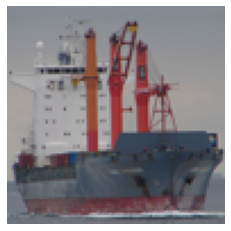

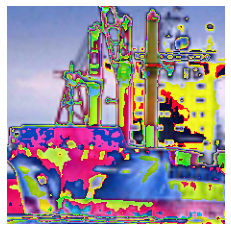

In [10]:
### 데이터 정규화를 위해 train data의 R,G,B mean std를 구함
meanRGB = [np.mean(x.numpy() , axis=(1,2)) for x, _ in train_data]
stdRGB = [np.std(x.numpy() , axis=(1,2)) for x, _ in train_data]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

### image abulmentation
# In paper, using FiveCrop, normalize, horizontal reflection
# 논문에서는 FiveCrop을 하여 데이터 증강을 하였지만, 여기서는 구현 CenterCrop(or RandomCrop)을 사용함.
train_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]) # 아까 구한 mean, std
])

test_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanR], [stdR, stdG, stdB]),
    transforms.Resize(227),
])

### 샘플 데이터 확인
random_idx = int(np.random.choice(len(train_data), 1))
sample_img, label = train_data[random_idx]

plt.imshow(transforms.ToPILImage()(sample_img))
plt.axis('off')
plt.show()

# train_data, test_data transformer 적용
train_data.transform = train_transformer
valid_data.dataset.transform = test_transformer
test_data.dataset.transform = test_transformer

### transformer 적용 샘플 데이터 확인
sample_img, label = train_data[random_idx]

plt.imshow(transforms.ToPILImage()(sample_img))
plt.axis('off')
plt.show()

### DataLoader 
train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

#### 7. Alexnet 정의 

In [11]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet,self).__init__()
        # input size : (b x 3 x 227 x 227)
        # 논문에는 image 크기가 224 pixel이라고 나와 있지만, 오타입니다.
        # 227x227을 사용합니다.

        # Conv layer
        self.net = nn.Sequential(
            # 1st Conv : conv, relu, lrm, pool
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0), # 227 -> 55 
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # 55 -> 27

            # 2th Conv : conv, relu, lrm, pool 
            # 패딩이 2이면 아래 위, 오른쪽 왼쪽에 2개씩 추가되어 kernel_size를 5을 주어도 img 사이즈가 유지됨.
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2), # 27->27
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # 13

            # 3rd Conv : conv, relu
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1), # 13->13
            nn.ReLU(inplace=True),

            # 4th Conv : conv, relu
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1), # 13->13
            nn.ReLU(inplace=True),

            # 5th Conv : conv, relu, lrm, pool
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1, stride=1), # 13->13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 13->6 (256 x 6 x 6)
        )

        # fc layer
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

        # weight initialization
        self.init_weight()
    
    # 표준화 및 bias 초기화
    def init_weight(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                # conv2d 레이어들을 가우시안 분로로 표준화하고 bias는 0으로 초기화한다.
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # In paper, initialize bias to 1 for conv2, 4, 5 layer (논문에 나온거 처럼 2,4,5 conv layer는 bias를 1로 초기화)
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)
    
    def forward(self,x):
        # multi GPU는 적용하기 않음
        x = self.net(x)
        x = x.view(-1, 256 * 6* 6)
        logits = self.classifier(x)
        #probs = F.softmax(logits, dim=1)
        return logits  # probs

#### 8. model, optimizer, loss function 설정 

In [12]:
# check the model
from torchsummary import summary

model = AlexNet(N_CLASSES).to(DEVICE)
summary(model, input_size=(3, 227, 227), device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [13]:
# weight 초기화 확인
# for p in model.parameters():
#     print(p)
#     break

In [13]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

criterion = nn.CrossEntropyLoss()

Epoch 0/4, current lr=0.001
12:05:51 --- Epoch: 0	Train loss: 0.0578	Valid loss: 0.1794	Train accuracy: 0.09375	Valid accuracy: 0.1015625
[Copy best model weights]
Epoch 1/4, current lr=0.001
12:05:52 --- Epoch: 1	Train loss: 0.0579	Valid loss: 0.1796	Train accuracy: 0.0703125	Valid accuracy: 0.1015625
Epoch 2/4, current lr=0.001
12:05:52 --- Epoch: 2	Train loss: 0.0583	Valid loss: 0.1799	Train accuracy: 0.1015625	Valid accuracy: 0.0546875
Epoch 3/4, current lr=0.001
12:05:53 --- Epoch: 3	Train loss: 0.0584	Valid loss: 0.1797	Train accuracy: 0.0859375	Valid accuracy: 0.0546875
Epoch 4/4, current lr=0.001
12:05:53 --- Epoch: 4	Train loss: 0.0577	Valid loss: 0.1793	Train accuracy: 0.109375	Valid accuracy: 0.0546875
[Copy best model weights]


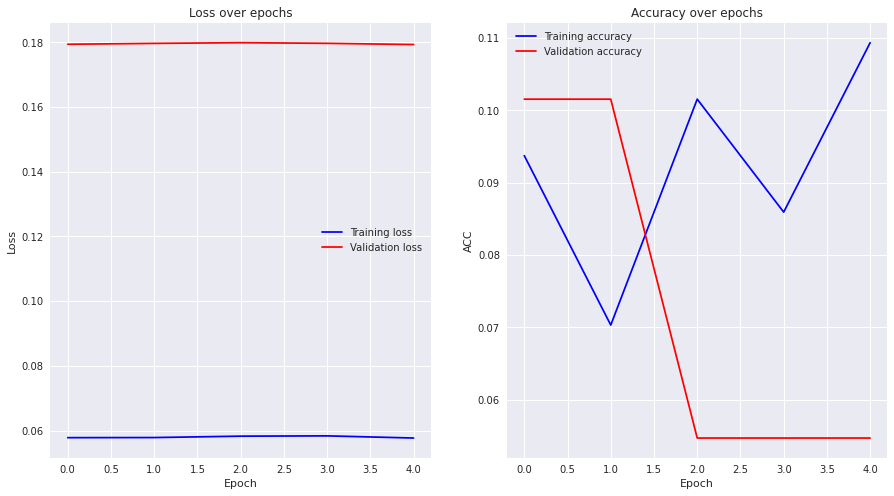

In [15]:
# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

params = dict()

params['model'] = model 
params['criterion'] = criterion
params['optimizer'] = optimizer
params['lr_scheduler'] = lr_scheduler
params['train_loader'] = train_dl
params['valid_loader'] = valid_dl
params['n_epochs'] = 5
params['device'] = DEVICE
params['path2weights'] = './models/Alexnet_weights.pt'
params['sanity_check'] = False

model, optimizer, hist = training_loop(params)

### Pytorch pretrained model load

In [16]:
import torchvision.models as models

In [18]:
model = models.alexnet(pretrained=True)

num_in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features=num_in_features, out_features=10, bias=True)

model = model.to(DEVICE)

Epoch 0/9, current lr=0.001
12:06:13 --- Epoch: 0	Train loss: 2.4501	Valid loss: 2.3892	Train accuracy: 0.11639999598264694	Valid accuracy: 0.13499999046325684
[Copy best model weights]
Epoch 1/9, current lr=0.001
12:06:25 --- Epoch: 1	Train loss: 2.4276	Valid loss: 2.3892	Train accuracy: 0.11800000071525574	Valid accuracy: 0.13499999046325684
Epoch 2/9, current lr=0.001
12:06:36 --- Epoch: 2	Train loss: 2.4430	Valid loss: 2.3892	Train accuracy: 0.11639999598264694	Valid accuracy: 0.13499999046325684
Epoch 3/9, current lr=0.001
12:06:47 --- Epoch: 3	Train loss: 2.4341	Valid loss: 2.3892	Train accuracy: 0.11979999393224716	Valid accuracy: 0.13499999046325684
Epoch 4/9, current lr=0.001
12:06:58 --- Epoch: 4	Train loss: 2.4392	Valid loss: 2.3892	Train accuracy: 0.11219999939203262	Valid accuracy: 0.13499999046325684
Epoch 5/9, current lr=0.0001
12:07:10 --- Epoch: 5	Train loss: 2.4359	Valid loss: 2.3892	Train accuracy: 0.11539999395608902	Valid accuracy: 0.13499999046325684
Epoch 6/9, cu

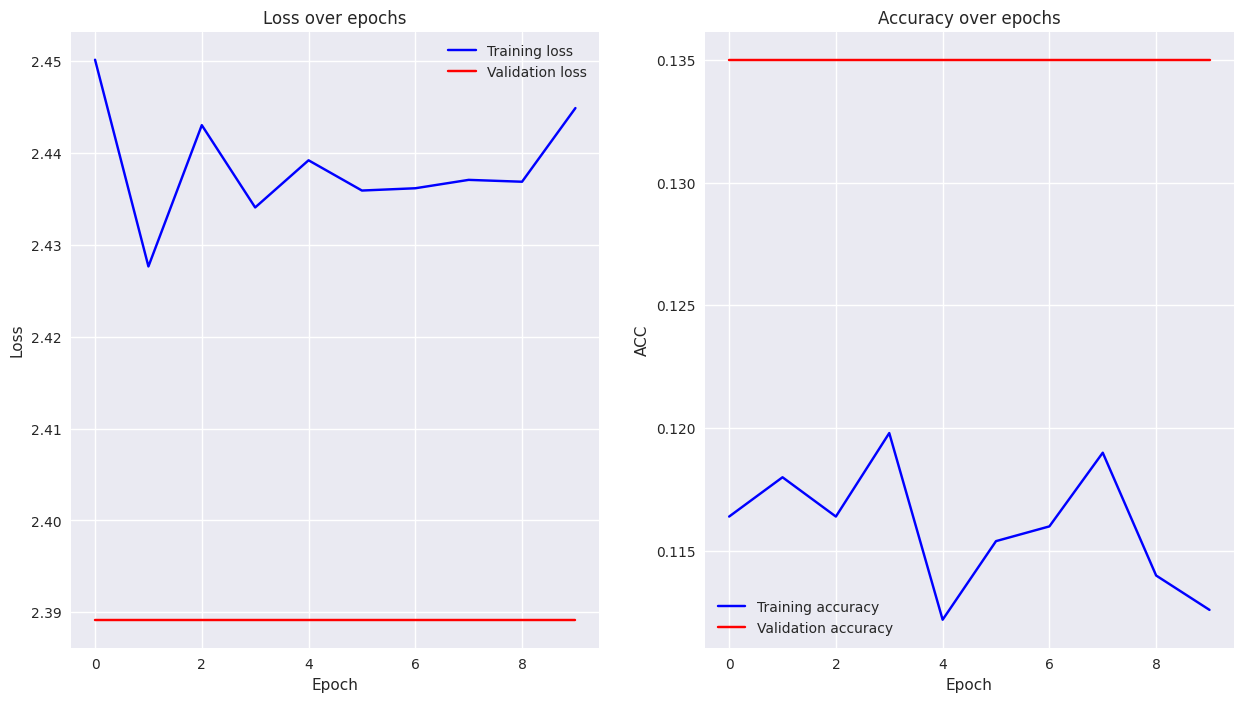

In [20]:
params = dict()

params['model'] = model 
params['criterion'] = criterion
params['optimizer'] = optimizer
params['lr_scheduler'] = lr_scheduler
params['train_loader'] = train_dl
params['valid_loader'] = valid_dl
params['n_epochs'] = 10
params['device'] = DEVICE
params['path2weights'] = './models/Alexnet_weights.pt'
params['sanity_check'] = False

model, optimizer, hist = training_loop(params)